In [30]:
# IMPORTING REQUIRED LIBS
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# READING THE DATASET
df = pd.read_csv("/content/drive/MyDrive/markov/Initial_Dataset.csv")
len(df)
print(df.tail())

                                                    text label_sexist
13995  complexes like the 'nice chicks' that go after...       sexist
13996  "GRAPHIC Germany - Muslim "refugee" stabbing h...   not sexist
13997  Lol I imagine there would be simps that are li...   not sexist
13998  It's not, the girls I go on dates with don't k...   not sexist
13999  How can he be an incel? He does have a girlfri...   not sexist


In [6]:
# IMPORT REQUIRED LIBS
import pandas as pd

In [8]:
# READ DATASET
df = pd.read_csv("/content/drive/MyDrive/markov/Initial_Dataset.csv")
print(df.tail())
len(df)

                                                    text label_sexist
13995  complexes like the 'nice chicks' that go after...       sexist
13996  "GRAPHIC Germany - Muslim "refugee" stabbing h...   not sexist
13997  Lol I imagine there would be simps that are li...   not sexist
13998  It's not, the girls I go on dates with don't k...   not sexist
13999  How can he be an incel? He does have a girlfri...   not sexist


14000

In [15]:
# TEXT PREPROCESSING

# removes HTML tags and removes punctuation from the text
def clean_text(text):
  text = text.lower() 
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'www\S+', '', text) 
  text = re.sub(r'<.*?>', '', text)  
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub('\s+', ' ', text) 
  return text

# removes common words such as "the" and "a" from the text
def remove_stopword(text, stopwords):
  return " ".join([word for word in text.split() if word not in (stop_words)])

# split sentences into words
def tokenize(text):
  return text.split()

# reduces words to their base forms using lemmatization
def lemma_text(text, lemmatizer):
  lemmatized_words = [lemmatizer.lemmatize(word) for word in tokenize(text)]
  return " ".join(lemmatized_words)

# combines these three functions to clean and preprocess the text
def process_text(text, lemmatizer, stop_words):
  text = clean_text(text)
  text = remove_stopword(text, stop_words)
  text = lemma_text(text, lemmatizer)
  return text 

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# stores the result in a new column called 'processed_text'
df["processed_text"] = df['text'].apply(process_text, lemmatizer = lemmatizer, stop_words = stop_words)
df.head(10)

,text,label_sexist,processed_text
0,"Damn, this writing was pretty chaotic",not sexist,damn writing pretty chaotic
1,"Yeah, and apparently a bunch of misogynistic v...",not sexist,yeah apparently bunch misogynistic virgin one ...
2,How the FUCK is this woman still an MP!!!???,not sexist,fuck woman still mp
3,Understand. Know you're right. At same time I ...,not sexist,understand know youre right time know isnt eno...
4,Surprized they didn't stop and rape some women,not sexist,surprized didnt stop rape woman
5,yeah but in order to keep the benefit i have t...,not sexist,yeah order keep benefit good tommorow told cou...
6,Hahaha I just wish they would live their truth...,not sexist,hahaha wish would live truth cut shit wouldnt ...
7,head mod said she talked to him after he made ...,not sexist,head mod said talked made post wont tell anyon...
8,"just the inside of your wallet: cash, bank car...",sexist,inside wallet cash bank card credit card debit...
9,We most definitely did. I didn’t go too much i...,not sexist,definitely didnt go much detail happened put s...


In [19]:
# SEPARATING THE DATA CLASSES
class_notsexist, class_sexist = df['label_sexist'].value_counts()
class_s = df[df['label_sexist'] == "sexist"]
class_ns = df[df['label_sexist'] == "not sexist"]
print('class_sexist:', class_s.shape)
print('class_notsexist:', class_ns.shape)

class_sexist: (3398, 3)
class_notsexist: (10602, 3)


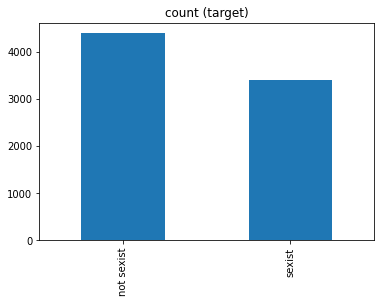

In [22]:
# UNDER SAMPLING 
# only 1000 additional samples, this is done to address imbalanced classes
class_ns_under = class_ns.sample(class_sexist+1000)
df_under = pd.concat([class_ns_under, class_s], axis=0)
df_under['label_sexist'].value_counts().plot(kind='bar', title='count (target)')

In [25]:
# CREATING TF-IDF FEATURE MATRIX
# To create feature vectors from the preprocessed text data.
tfidf = TfidfVectorizer()
tfidf_text_vec = tfidf.fit_transform(df_under.processed_text)

In [26]:
# TRAIN-TEST SPLITTING
x_train_a, x_test_a, y_train_a, y_test_a = train_test_split(tfidf_text_vec, df_under['label_sexist'], test_size=0.2, train_size=0.8, random_state=5, shuffle=True)

RANDOM FOREST CLASSIFIER

In [29]:
rf_clf = RandomForestClassifier().fit(x_train_a, y_train_a)
rf_pred = rf_clf.predict(x_test_a)
acc = accuracy_score(rf_pred, y_test_a)
print("Accuracy:",str('{:04.2f}'.format(acc*100))+'%')
print(classification_report(y_test_a, rf_pred))
clsf_report = pd.DataFrame(classification_report(y_test_a, rf_pred, output_dict=True)).transpose()
clsf_report.to_csv("/content/drive/MyDrive/markov/report_random_forest.csv", index=True)

Accuracy: 74.62%
              precision    recall  f1-score   support

  not sexist       0.73      0.86      0.79       883
      sexist       0.77      0.59      0.67       677

    accuracy                           0.75      1560
   macro avg       0.75      0.73      0.73      1560
weighted avg       0.75      0.75      0.74      1560



XGBOOST CLASSIFIER

In [33]:
# LABEL ENCODING
# 0-not sexist, 1-sexist
le = LabelEncoder()
y_train_a_enc = le.fit_transform(y_train_a)
y_test_a_enc = le.fit_transform(y_test_a)

In [34]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=5)
xgb_model.fit(x_train_a, y_train_a_enc)

y_pred = xgb_model.predict(x_test_a)
y_pred_enc = le.fit_transform(y_pred)

acc = accuracy_score(y_pred_enc, y_test_a_enc)
print("Accuracy:",str('{:04.2f}'.format(acc*100))+'%')
print(classification_report(y_test_a_enc, y_pred_enc))
clsf_report = pd.DataFrame(classification_report(y_test_a_enc, y_pred_enc, output_dict=True)).transpose()
clsf_report.to_csv("/content/drive/MyDrive/markov/report_xgboost.csv", index= True)

Accuracy: 73.85%
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       883
           1       0.72      0.65      0.68       677

    accuracy                           0.74      1560
   macro avg       0.74      0.73      0.73      1560
weighted avg       0.74      0.74      0.74      1560

